# Choose settings

##### Choose your settings here

In [1]:
# choose dataset
DATASET_NAME = 'cats-vs-dogs-large'  # needs to match folder name in FM/datasets
USE_CACHED_EMBEDDINGS = ['ALIGN_cats-vs-dogs-large.pkl', 'CLIP_cats-vs-dogs-large.pkl']

# choose which model to use to generate the embeddings
MODELS = ['ALIGN', 'CLIP']

PLOT_DPI = 75  # 75 for small figures and 300 for good quality

##### This part is calculated automatically

In [2]:
root_path = '/content/drive/My Drive/FM/'
datasets_path = root_path + 'datasets/'
dataset_path = datasets_path + DATASET_NAME + '/'

if DATASET_NAME == 'cats-vs-dogs-large' or DATASET_NAME == 'train-small':
  LABELS = ['cat', 'dog']
elif DATASET_NAME == 'jellyfish-classification':
  LABELS = ['barrel jellyfish', 'compass jellyfish', 'lions mane jellyfish', 'moon jellyfish']
elif DATASET_NAME == 'traffic-signs':
  LABELS = ['30 kilometers per hour speed limit traffic sign', '80 kilometers per hour speed limit traffic sign', '100 kilometers per hour speed limit traffic sign', 'give way traffic sign', 'no entry traffic sign', 'no overtaking traffic sign', 'priority over oncoming traffic sign', 'stop sign']
else:
  raise ValueError('Invalid dataset selected or labels not set!')

# Load libraries

In [3]:
# hacky way when hitting "run all" that libraries are not reloaded
try:
  torch.tensor([[0]])
  libraries_already_loaded = True
except:
  libraries_already_loaded = False

In [4]:
if not libraries_already_loaded:
  ! pip install ftfy regex tqdm
  ! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 2.0 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-5p_7_xh5
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-5p_7_xh5
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=a769aa94a4e8ef5f143506595ec36c2169224bb34029cd163f7ae219f39d7834
  Stored in directory: /tmp/pip-ephem-wheel-cache-zuhvyptk/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [5]:
if not libraries_already_loaded:
  import torch
  from torchvision import transforms
  import clip
  from transformers import AutoImageProcessor, ViTModel, AlignProcessor, AlignModel, AutoTokenizer
  from transformers.tokenization_utils_base import BatchEncoding
  import numpy as np
  from matplotlib import pyplot as plt
  from PIL import Image
  from pkg_resources import packaging
  import os
  from google.colab import drive
  from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
  import glob
  import pickle
  from scipy.spatial.distance import cosine

print("Torch version:", torch.__version__)
plt.rcParams['figure.dpi'] = PLOT_DPI
plt.rcParams['savefig.dpi'] = PLOT_DPI

Torch version: 2.1.0+cu121


In [6]:
def calculate_column_average(matrix):
    """
    Calculates the average for each column in a PyTorch matrix.

    Parameters:
    - matrix: torch.Tensor
        The input matrix for which the column averages are to be calculated.

    Returns:
    - torch.Tensor
        A tensor containing the average value for each column of the input matrix.

    Raises:
    - TypeError:
        Raises an error if the input is not a PyTorch tensor.
    - ValueError:
        Raises an error if the input tensor is empty or has zero columns.
    """

    # Checking if the input is a PyTorch tensor
    if not isinstance(matrix, torch.Tensor):
        raise TypeError("Input should be a PyTorch tensor.")

    # Checking if the input tensor is empty or has zero columns
    if matrix.numel() == 0 or matrix.size(1) == 0:
        raise ValueError("Input tensor is empty or has zero columns.")

    # Calculating the column averages but taking out the entry for the same vector in the matrix (diagonal entry)
    column_sums = torch.sum(matrix, dim=0)
    column_counts = torch.tensor([matrix.size(0)] * (matrix.size(1)), dtype=torch.float32)
    column_averages = (column_sums -1) / (column_counts - 1)

    return column_averages

def cosine_similarity_matrix(embeddings_tensor):
    """
    Function to compute a similarity matrix using dot product

    Parameters:
    - embeddings: list of torch.Tensor
        List of embeddings of images produced with CLIP.

    Returns:
    - similarity_matrix: numpy.ndarray
        2D numpy array representing the similarity matrix between the embeddings.
        Each element (i, j) in the matrix represents the similarity between embeddings[i] and embeddings[j].
        The similarity score between the two embeddings is calculated using cos similarity. The score ranges from 0 to 1,
        where 0 indicates completely dissimilar embeddings and 1 indicates identical embeddings.
    """

    """
    # Calculating the cosine distance between the two embeddings
    distance = cosine(embedding1, embedding2)

    # Converting the distance to similarity score
    similarity = 1 - distance

    return similarity
    """

    # Normalizing the embeddings
    embeddings_tensor = torch.nn.functional.normalize(embeddings_tensor, dim=1)

    # Computing the similarity matrix using dot product
    similarity_matrix = torch.matmul(embeddings_tensor, embeddings_tensor.T)

    return similarity_matrix

from sklearn.metrics.pairwise import cosine_similarity as cosine_similarity_sklearn
def cosine_similarity(x, y=None):
  if y is None:
    return cosine_similarity_matrix(x)
  return cosine_similarity_sklearn(x, y)

# Mounting storage

In [7]:
drive.mount('/content/drive')
!ls "{root_path}"

Mounted at /content/drive
 align_embeddings_gen.ipynb	  Experimental_Anni.ipynb	     ml_dl_benchmark.ipynb
 align_secondary.ipynb		  Experimental_Boshra.ipynb	     model_weights
 benchmark_script.ipynb		  Experimental_GenAI+ML_Anni.ipynb   pollution_files.txt
'Copy of ml_dl_benchmark.ipynb'   experiments_to_fix_metrics_plots   results
 datasets			  helper_scripts		     Untitled0.ipynb
 Evaluation.gdoc		  ml_dl_benchmark_1%external.ipynb


# Load model

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"


class Align(torch.nn.Module):

  def __init__(self):
    super().__init__()
    self.align = AlignModel.from_pretrained("kakaobrain/align-base")

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.align(x)

  def encode_image(self, img: torch.Tensor) -> torch.Tensor:
    return self.align.get_image_features(img)

  def encode_text(self, text: BatchEncoding) -> torch.Tensor:
    return self.align.get_text_features(**text)


models = []
tokenizers = []

for model_name in MODELS:

  if model_name == 'CLIP':
    model, _ = clip.load("ViT-B/32", device=device)
    tokenize = clip.tokenize
  elif model_name == 'ALIGN':
    model = Align().to(device)
    tokenizer = AutoTokenizer.from_pretrained("kakaobrain/align-base")
    tokenize = lambda s: tokenizer([s], padding=True, return_tensors="pt")
  else:
    raise ValueError(f'Invalid model {model_name} selected!')

  model.eval()
  models.append(model)
  tokenizers.append(tokenize)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/5.25k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/690M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 138MiB/s]


# Load dataset

In [9]:
image_embeddings = []
text_embeddings = []

for i, cached_embeddings in enumerate(USE_CACHED_EMBEDDINGS):

  # load embeddings of previous execution from pickle file
  pickle_file = datasets_path + cached_embeddings
  with open(pickle_file, 'rb') as f:
    image_embeddings.append(pickle.load(f))
  print('Embeddings loaded from', pickle_file)

  # save embedding dimension for creation of reference vectors etc.
  embedding_dim = image_embeddings[-1][LABELS[0]].shape[1]

  # embed corresponding text
  text_embeddings.append({})
  for label in LABELS:
    with torch.no_grad():
      text_embeddings[-1][label] = models[i].encode_text(tokenizers[i](label).to(device)).cpu()

Embeddings loaded from /content/drive/My Drive/FM/datasets/ALIGN_cats-vs-dogs-large.pkl
Embeddings loaded from /content/drive/My Drive/FM/datasets/CLIP_cats-vs-dogs-large.pkl


# Compare embeddings of the models

##### Function for creating boxplots

In [10]:
def show_boxplot(similarity_values, title_text):

  x_axis = [i+1 for i in range(len(similarity_values.keys()))]
  means = np.array([np.mean(similarity_values[label]) for label in similarity_values.keys()])
  stds = np.array([np.std(similarity_values[label]) for label in similarity_values.keys()])

  fig, ax = plt.subplots()
  ax.boxplot(list(similarity_values.values()))
  ax.scatter(x_axis, means, color='green', label='mean')
  ax.scatter(x_axis * 2, list(means - stds) + list(means + stds), color='red', label='mean ± std')
  ax.set_xticklabels([label for label in similarity_values.keys()], rotation=90)
  ax.set_title(title_text)
  plt.legend()
  plt.grid(linestyle='dotted', axis='y')
  plt.show()

##### Get similarity values for text embedding:

ALIGN
Median magnitude of cat image embedding: 8.949800491333008
Median magnitude of dog image embedding: 8.804144859313965
magnitude of "cat" text embedding: 46838.74609375


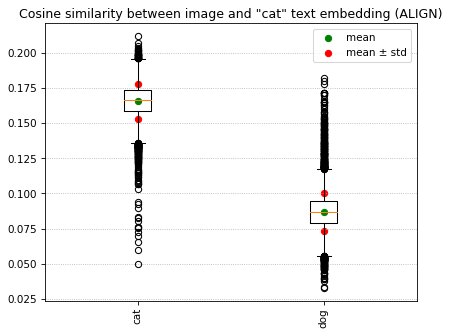

CLIP
Median magnitude of cat image embedding: 11.005620956420898
Median magnitude of dog image embedding: 11.049405097961426
magnitude of "cat" text embedding: 10.44452953338623


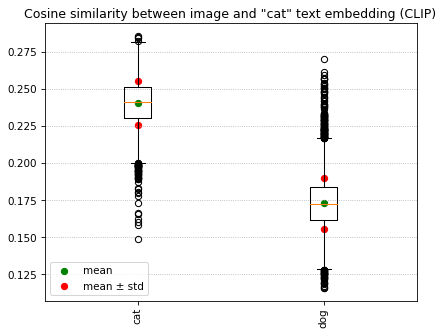

ALIGN
Median magnitude of cat image embedding: 8.949800491333008
Median magnitude of dog image embedding: 8.804144859313965
magnitude of "dog" text embedding: 46114.9140625


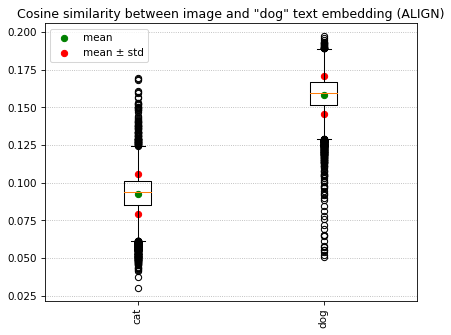

CLIP
Median magnitude of cat image embedding: 11.005620956420898
Median magnitude of dog image embedding: 11.049405097961426
magnitude of "dog" text embedding: 10.925101280212402


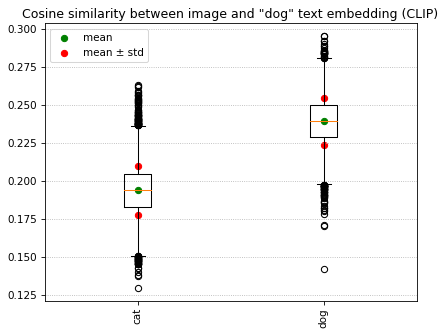

In [15]:
for true_label in LABELS:
  for i in range(len(text_embeddings)):
    similarity_values = {}
    print(MODELS[i])
    for label in LABELS:
      similarity_values[label] = [cos_sim[0] for cos_sim in cosine_similarity(image_embeddings[i][label], text_embeddings[i][true_label])]
      print(f'Median magnitude of {label} image embedding: {np.median(torch.linalg.vector_norm(image_embeddings[i][label], dim=1))}')
    print(f'magnitude of "{true_label}" text embedding: {torch.linalg.vector_norm(text_embeddings[i][true_label])}')
    show_boxplot(similarity_values, f'Cosine similarity between image and "{true_label}" text embedding ({MODELS[i]})')